In [10]:
import pandas as pd

In [30]:
sell_in_leroymerlin = pd.read_csv("Data/Raw/leroy_merlin/CA SELL IN LM 22 23.csv")
sell_in_leroymerlin.columns = [
    'code_point_vente', 'raison_sociale', 'code_postal', 'ville',
    'code_chef_secteur_henkel', 'total_famille', 'famille',
    'total_annuel_2022', 'total_annuel_2023', 'total_annuel_evol(%)',
    'total_ytd_2022', 'total_ytd_2023', 'total_ytd_evol',
    'janvier_2022', 'janvier_2023', 'janvier_evol', 'fevrier_2022',
    'fevrier_2023', 'fevrier_evol', 'mars_2022', 'mars_2023',
    'mars_evol', 'avril_2022', 'avril_2023', 'avril_evol', 'mai_2022',
    'mai_2023', 'mai_evol', 'juin_2022', 'juin_2023', 'juin_evol',
    'juillet_2022', 'juillet_2023', 'juillet_evol', 'aout_2022',
    'aout_2023', 'aout_evol', 'septembre_2022', 'septembre_2023',
    'septembre_evol', 'octobre_2022', 'octobre_2023', 'octobre_evol',
    'novembre_2022', 'novembre_2023', 'novembre_evol', 'decembre_2022',
    'decembre_2023', 'decembre_evol'
]
sell_in_leroymerlin['famille'] = sell_in_leroymerlin['total_famille'].combine_first(sell_in_leroymerlin['famille'])
sell_in_leroymerlin.drop(columns=['total_famille'], inplace=True)
sell_in_leroymerlin.famille=sell_in_leroymerlin.famille.str.replace('-','').str.strip().str.lower()
sell_in_leroymerlin['total_annuel_evol(%)']=sell_in_leroymerlin['total_annuel_evol(%)'].str.replace('%','').str.replace(',','.').astype(float)

visite_annuelle_leroymerlin = pd.read_csv("Data/Raw/leroy_merlin/VISITES ANNUELLES 22 23.csv")
visite_annuelle_leroymerlin.columns = [
    'CodeInterne', 
    'RaisonSociale', 
    'Ville', 
    'CodePostal', 
    'Visites2022', 
    'Visites2023'
]

pp_22_23_leroymerlin = pd.read_csv("Data/Raw/leroy_merlin/PP 22 23.csv")
pp_22_23_leroymerlin.columns = [
    'annee', 'code_point_vente', 'code_idh', 'raison_sociale',
    'code_postal', 'ville', 'code_chef_secteur', 'rayon', 'nature',
    'type_accord', 'statut_accord', 'modalites', 'paiement', 'periode',
    'budget_accord_ht'
]


In [31]:
# Renommer les colonnes pour faciliter la fusion
visite_annuelle_leroymerlin.rename(columns={'CodeInterne': 'code_point_vente'}, inplace=True)

# Fusionner les datasets
merged_df = pd.merge(pp_22_23_leroymerlin, sell_in_leroymerlin, on='code_point_vente')
merged_df = pd.merge(merged_df, visite_annuelle_leroymerlin, on='code_point_vente')

merged_df = merged_df[['code_point_vente','budget_accord_ht', 'total_annuel_2022', 'total_annuel_2023', 'total_ytd_2022', 'total_ytd_2023', 'Visites2022', 'Visites2023']]
# Nettoyer la colonne 'budget_accord_ht'
merged_df['budget_accord_ht'] = merged_df['budget_accord_ht'].str.replace(',', '.')
merged_df['budget_accord_ht'] = merged_df['budget_accord_ht'].str.replace('€', '')
merged_df['budget_accord_ht'] = merged_df['budget_accord_ht'].str.replace('\u202f', '')
merged_df['budget_accord_ht'] = merged_df['budget_accord_ht'].str.strip()
merged_df['budget_accord_ht'] = merged_df['budget_accord_ht'].astype(float)

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Sélectionner les colonnes pertinentes
features = merged_df[['total_annuel_2022', 'total_annuel_2023', 'total_ytd_2022', 'total_ytd_2023', 'Visites2022', 'Visites2023']]
target = merged_df['budget_accord_ht']  # Exemple de variable cible

# Gérer les valeurs manquantes dans les features et la target
features = features.fillna(features.mean())
target = target.fillna(target.mean())

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
print(f'Erreur quadratique moyenne: {mse}')
print(f'Coefficient de détermination R^2: {r2}')

# Ajouter les prédictions au DataFrame
merged_df['predictions'] = model.predict(features)

# Trier les magasins en fonction des prédictions
sorted_df = merged_df.sort_values(by='predictions', ascending=False)

# Afficher les noms des magasins avec les meilleures performances prévues
top_investment_stores = sorted_df[['code_point_vente', 'predictions']]
print("Magasins dans lesquels investir :")
top_investment_stores=top_investment_stores.groupby('code_point_vente').mean().sort_values(by='predictions', ascending=False).reset_index()

Erreur quadratique moyenne: 5623295.746534928
Coefficient de détermination R^2: 0.18932118499484274
Magasins dans lesquels investir :


In [77]:
from sklearn.preprocessing import MinMaxScaler

# Créer un scaler MinMax
scaler = MinMaxScaler()

# Normaliser les prédictions pour qu'elles soient entre 0 et 1
top_investment_stores['predictions'] = scaler.fit_transform(top_investment_stores[['predictions']])

# Afficher les prédictions normalisées
top_investment_stores.to_csv('Data/Processed/leroy_merlin/top_investment_stores.csv', index=False)
top_investment_stores

,code_point_vente,predictions
0,20rhf,1.000000
1,20r4m,0.905853
2,20rkz,0.831284
3,20rjz,0.815480
4,20r5r,0.812956
...,...,...
119,20pym,0.169160
120,20pf3,0.164520
121,20pky,0.164161
122,20nx4,0.142092


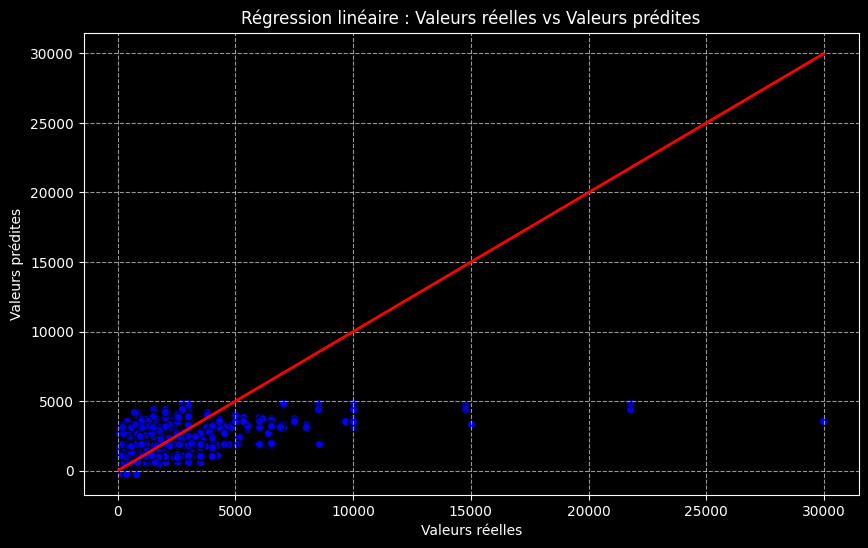

In [75]:
import matplotlib.pyplot as plt
# Tracer le graphique de la régression linéaire
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Régression linéaire : Valeurs réelles vs Valeurs prédites')
plt.style.use('dark_background')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('Data/Processed/leroy_merlin/linear_regression_leroy.png')

In [59]:
# Bricomarché
visite_annuelle_bricomarche = pd.read_csv("Data/Raw/bricomarche/VISITES ANNUELLES 22 23.csv")
visite_annuelle_bricomarche.columns = [
    'CodeInterne', 
    'RaisonSociale', 
    'Ville', 
    'CodePostal', 
    'Visites2022', 
    'Visites2023'
]

pp_22_23_bricomarche = pd.read_csv("Data/Raw/bricomarche/PP 22 23.csv")
pp_22_23_bricomarche.columns = [
    'annee', 'code_point_vente', 'raison_sociale', 'code_postal',
    'ville', 'code_chef_secteur_henkel', 'rayon', 'nature',
    'type_accord', 'modalites', 'budget_accord_ht'
]

sell_in_bricomarche = pd.read_csv("Data/Raw/bricomarche/Données brutes SELL IN 22 23.csv")
sell_in_bricomarche.columns = [
    'code_point_vente', 'raison_sociale', 'code_postal', 'ville',
    'code_chef_secteur_henkel', 'total_famille', 'famille',
    'total_annuel_2022', 'total_annuel_2023', 'total_annuel_evol(%)',
    'total_ytd_2022', 'total_ytd_2023', 'total_ytd_evol',
    'janvier_2022', 'janvier_2023', 'janvier_evol', 'fevrier_2022',
    'fevrier_2023', 'fevrier_evol', 'mars_2022', 'mars_2023',
    'mars_evol', 'avril_2022', 'avril_2023', 'avril_evol', 'mai_2022',
    'mai_2023', 'mai_evol', 'juin_2022', 'juin_2023', 'juin_evol',
    'juillet_2022', 'juillet_2023', 'juillet_evol', 'aout_2022',
    'aout_2023', 'aout_evol', 'septembre_2022', 'septembre_2023',
    'septembre_evol', 'octobre_2022', 'octobre_2023', 'octobre_evol',
    'novembre_2022', 'novembre_2023', 'novembre_evol', 'decembre_2022',
    'decembre_2023', 'decembre_evol'
]
sell_in_bricomarche['famille'] = sell_in_bricomarche['total_famille'].combine_first(sell_in_bricomarche['famille'])
sell_in_bricomarche.drop(columns=['total_famille'], inplace=True)
sell_in_bricomarche.famille=sell_in_bricomarche.famille.str.replace('-','').str.strip().str.lower()
sell_in_bricomarche['total_annuel_evol(%)']=sell_in_bricomarche['total_annuel_evol(%)'].str.replace('%','').str.replace(',','.').astype(float)

# Renommer les colonnes pour faciliter la fusion
visite_annuelle_bricomarche.rename(columns={'CodeInterne': 'code_point_vente'}, inplace=True)

# Fusionner les datasets
merged_df_2 = pd.merge(pp_22_23_bricomarche, sell_in_bricomarche, on='code_point_vente')
merged_df_2 = pd.merge(merged_df_2, visite_annuelle_bricomarche, on='code_point_vente')

merged_df_2.reset_index(drop=True, inplace=True)

merged_df_2 = merged_df_2[['code_point_vente','budget_accord_ht', 'total_annuel_2022', 'total_annuel_2023', 'total_ytd_2022', 'total_ytd_2023', 'Visites2022', 'Visites2023']]
# Nettoyer la colonne 'budget_accord_ht'
merged_df_2['budget_accord_ht'] = merged_df_2['budget_accord_ht'].str.replace(',', '.')
merged_df_2['budget_accord_ht'] = merged_df_2['budget_accord_ht'].str.replace('€', '')
merged_df_2['budget_accord_ht'] = merged_df_2['budget_accord_ht'].str.replace('\u202f', '')
merged_df_2['budget_accord_ht'] = merged_df_2['budget_accord_ht'].str.strip()
merged_df_2['budget_accord_ht'] = merged_df_2['budget_accord_ht'].astype(float)

In [62]:
# Sélectionner les colonnes pertinentes pour les features
features_2 = merged_df_2[['total_annuel_2022', 'total_annuel_2023', 'total_ytd_2022', 'total_ytd_2023', 'Visites2022', 'Visites2023']]

# Gérer les valeurs manquantes dans les features
features_2 = features_2.fillna(features_2.mean())

# Prédire les valeurs de budget_accord_ht pour merged_df_2
predictions_2 = model.predict(features_2)

# Ajouter les prédictions au DataFrame
merged_df_2['predictions'] = predictions_2

# Évaluer le modèle sur merged_df_2
mse_2 = mean_squared_error(merged_df_2['budget_accord_ht'], predictions_2)
r2_2 = model.score(features_2, merged_df_2['budget_accord_ht'])

print(f'Erreur quadratique moyenne sur merged_df_2: {mse_2}')
print(f'Coefficient de détermination R^2 sur merged_df_2: {r2_2}')

# Afficher les prédictions
test = merged_df_2[['code_point_vente', 'predictions']].groupby('code_point_vente').mean().sort_values(by='predictions', ascending=False).reset_index()

Erreur quadratique moyenne sur merged_df_2: 11451250.415890899
Coefficient de détermination R^2 sur merged_df_2: -14.454535385028356


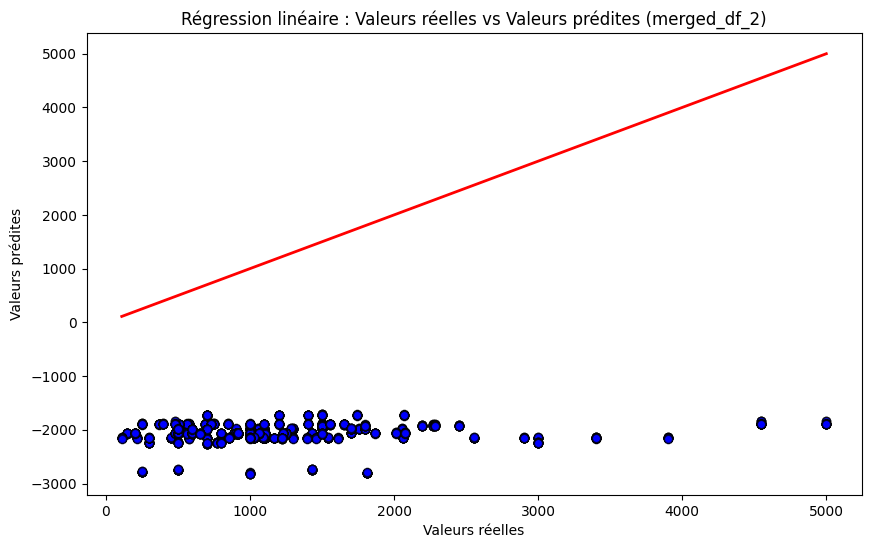

In [69]:
import matplotlib.pyplot as plt

# Tracer le graphique de la régression linéaire pour merged_df_2
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_2['budget_accord_ht'], merged_df_2['predictions'], color='blue', edgecolor='k', alpha=0.7)
plt.plot([merged_df_2['budget_accord_ht'].min(), merged_df_2['budget_accord_ht'].max()], 
         [merged_df_2['budget_accord_ht'].min(), merged_df_2['budget_accord_ht'].max()], 
         color='red', linewidth=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Régression linéaire : Valeurs réelles vs Valeurs prédites (merged_df_2)')
plt.show()